TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


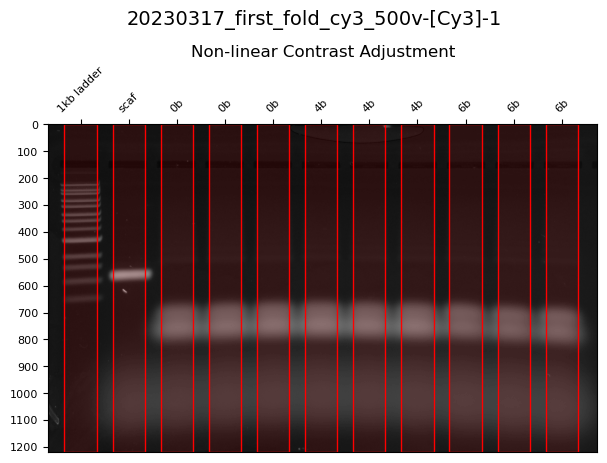

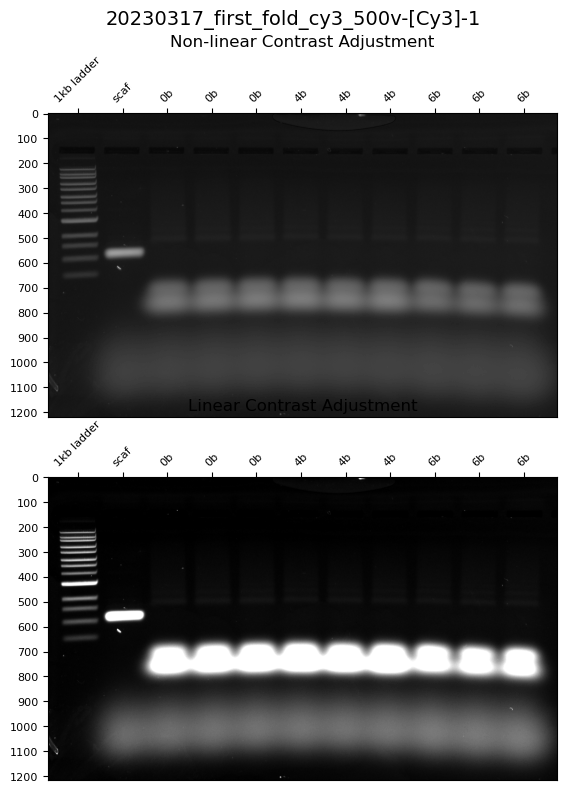

In [8]:
from gelpy import AgaroseGel

gel = AgaroseGel("data/20230317_first_fold_cy3_500v-[Cy3]-1.tif")
gel.setup_gel(labels=['1kb ladder', 'scaf', '0b', '0b', '0b', '4b', '4b', '4b', '6b', '6b', '6b'],
               x_label_pos=(120, 1910, 11), line_profile_width=120,
               img_height_factor=4)
gel.show_adjusted_images()

#gel.remove_background(model="2d_plane_fit")

,selected_lane_index,label,band_number,relative_area,maxima_position,Amplitude,Mean,Standard Deviation
0,0,1kb ladder,0,0.020,126.107,3.056e-03,126.107,2.627
1,0,1kb ladder,1,0.028,146.020,3.254e-03,146.020,3.389
2,0,1kb ladder,2,0.028,158.762,3.873e-03,158.762,2.874
3,0,1kb ladder,3,0.034,185.000,3.831e-03,185.000,3.536
4,0,1kb ladder,4,0.032,206.000,3.618e-03,206.000,3.546
5,0,1kb ladder,5,0.039,236.267,3.950e-03,236.267,3.889
6,0,1kb ladder,6,0.033,259.124,3.290e-03,259.124,3.955
7,0,1kb ladder,7,0.026,289.336,2.378e-03,289.336,4.326
8,0,1kb ladder,8,0.095,332.000,7.400e-03,332.000,5.145
9,0,1kb ladder,9,0.036,390.637,2.523e-03,390.637,5.684


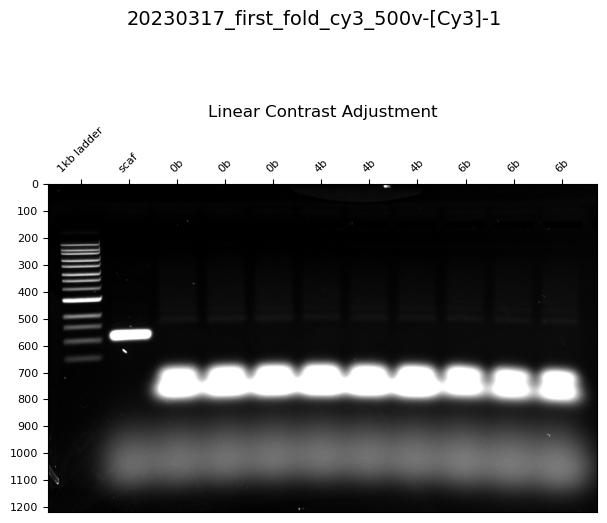

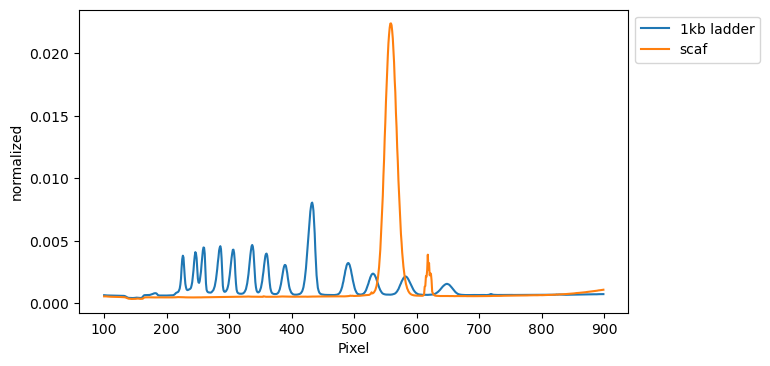

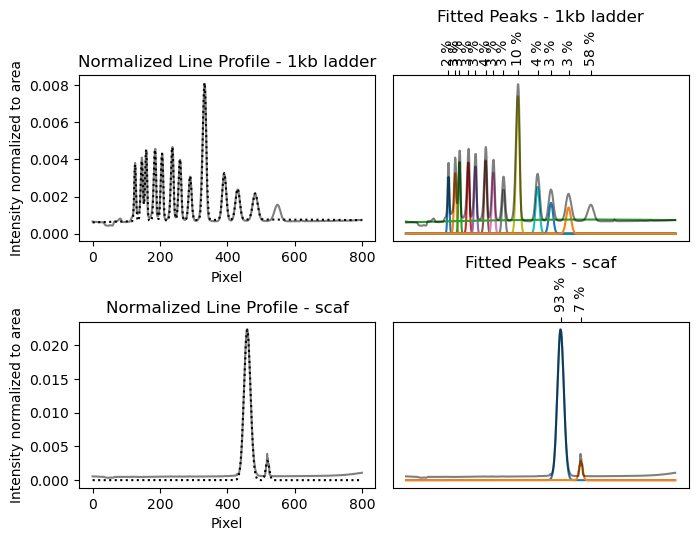

In [2]:

gel.show_adjusted_images(show_type="linear")
gel.show_line_profiles(select_lanes=[0,1],
                       slice_line_profile_length=(100, 900),
                       fit="gaussian",
                       maxima_prominence=0.0005, maxima_threshold=0.001,
                       plot_fits=True)